# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns 
import glob

!pip install xgboost

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer,SimpleImputer

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split,GridSearchCV

# Load Data

In [3]:
# Load all genre files
file_paths = glob.glob('training-data/*.csv')
genre_data = []

# Go through each genre, and use title name as genre column
for file in file_paths:
    genre = file.split('/')[-1].replace('.csv', '')  
    df = pd.read_csv(file)
    df['genre'] = genre  
    genre_data.append(df)

 # All training data 
train_df = pd.concat(genre_data)
# Test Data
test_df = pd.read_csv('testing-data/testing-instances.csv')

# Display DataFrames

## train_df

In [4]:
train_df

instance_id         artist_name                track_name  \
0           41581         empty_field                World News   
1          112136   Frightened Rabbit        Keep Yourself Warm   
2          128900         empty_field              All I Wanted   
3          173682  Elizabeth Mitchell  Little Bird, Little Bird   
4          196905     The Paper Kites        Don't Keep Driving   
...           ...                 ...                       ...   
4995       131460         empty_field     It's Been A Long Time   
4996       123400        Night Lovell                   Louis V   
4997       180590             Molotov                 Frijolero   
4998       125387         empty_field                 Mink Flow   
4999       180321         Joey Bada$$          Christ Conscious   

                    track_id  popularity  acousticness  danceability  \
0     18nTHX1dgL1R3fxxOEvTpK          42       0.01060         0.544   
1     597dz7YS9aUKQCBdFDahlZ          43       0.00363         0.261   
2     5nzEilkVhvnCD0xpW3raTy          40       0.83500         0.501   
3     0hihLCB6tescIIqSjujfa1          41       0.96000         0.487   
4     0FZmAvivvifvtN3pZScbw1          45       0.34900         0.349   
...                      ...         ...           ...           ...   
4995  2I9foKseoFQh07p6sD2voE          55       0.00745         0.839   
4996  57YxAGoOX78aDBTxe5fKJG          54       0.16100         0.724   
4997  3h64C58s1P6WsNu7ZMa0QY          67       0.09780         0.774   
4998  6fRLVZ4jKzuqyDPlIdbq9q          56       0.00355         0.692   
4999  4NH9CaE5G8KtsRMmpn0Thp          57       0.01310         0.649   

      duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0              -1   0.813          0.377000   E    0.3450    -8.871  Major   
1          333027   0.572          0.001340   G    0.1580    -5.480  Major   
2          201800   0.176          0.000629   F    0.1060   -12.868  Minor   
3              -1   0.223          0.007110   C    0.1210   -17.700  Minor   
4              -1   0.499          0.756000  F#    0.1270    -6.832  Major   
...           ...     ...               ...  ..       ...       ...    ...   
4995       237667   0.551          0.000020   B    0.0800    -7.484  Minor   
4996           -1   0.556          0.000004  C#    0.4870   -10.659  Major   
4997       210094   0.656          0.000000   D    0.0643    -4.215  Major   
4998       178787   0.533          0.000000  F#    0.1140    -6.165  Minor   
4999       173793   0.717          0.000033   E    0.1800    -5.021  Major   

      speechiness    tempo time_signature  valence    genre  
0          0.0398  121.892         04-Apr   0.5790     folk  
1          0.0323  114.052         04-Apr   0.0382     folk  
2          0.0338        ?         04-Apr   0.1250     folk  
3          0.3670  175.357         04-Apr   0.6410     folk  
4          0.0290  113.476         04-Apr   0.1150     folk  
...           ...      ...            ...      ...      ...  
4995       0.2290   88.727         04-Apr   0.8520  hip-hop  
4996       0.1480   120.06         04-Apr   0.2230  hip-hop  
4997       0.0357   95.007         04-Apr   0.8540  hip-hop  
4998       0.1760   78.902         04-Apr   0.2500  hip-hop  
4999       0.2620   86.798         04-Apr   0.5890  hip-hop  

[50000 rows x 19 columns]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  int64  
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   track_id          50000 non-null  object 
 4   popularity        50000 non-null  int64  
 5   acousticness      50000 non-null  float64
 6   danceability      50000 non-null  float64
 7   duration_ms       50000 non-null  int64  
 8   energy            50000 non-null  float64
 9   instrumentalness  50000 non-null  float64
 10  key               50000 non-null  object 
 11  liveness          50000 non-null  float64
 12  loudness          50000 non-null  float64
 13  mode              50000 non-null  object 
 14  speechiness       50000 non-null  float64
 15  tempo             50000 non-null  object 
 16  time_signature    50000 non-null  object 
 17 

## test_df

In [6]:
test_df

instance_id        artist_name  \
0                1      Michael Haydn   
1                2       Tee Grizzley   
2                3        Jethro Tull   
3                4  Susannah McCorkle   
4                5       Willie Colón   
...            ...                ...   
12430        12431       Modest Mouse   
12431        12432       Lana Del Rey   
12432        12433        empty_field   
12433        12434        empty_field   
12434        12435      Elliott Smith   

                                              track_name  \
0          Lauft, ihr Hirten, allzugleich, MH 217 (Live)   
1                                                Too Lit   
2                                                Hymn 43   
3                                    Forty-Second Street   
4                                       Eso Se Baila Asi   
...                                                  ...   
12430                      The Good Times Are Killing Me   
12431                                     In My Feelings   
12432                              Dat Dere - Remastered   
12433  Dame Tu Cosita (feat. Cutty Ranks) - Radio Ver...   
12434                                            Say Yes   

                     track_id  popularity  acousticness  danceability  \
0      5iGDehxYjg5YX025Mi2Iwd          28        0.9690         0.395   
1      1edknCYWzIaFbGX7YKfowe          54        0.1650         0.739   
2      4DM3zxFlei14ZOyKFtEx5p          38        0.0810         0.491   
3      4Egb5xP6cniUx0kgZd5zLB          43        0.8670         0.639   
4      67kJEhAjT5GtHGESOceau1          38        0.6790         0.636   
...                       ...         ...           ...           ...   
12430  7siD4wJRiNcC4680aiqOZg          47        0.3860         0.691   
12431  7zjzu90Q4mtNNaE9Ol9Zbv          65        0.0553         0.540   
12432  2TAQ9YGehOKWDqDak5DuXc          34        0.7840         0.583   
12433  5DzkVda3MOJo6tSvrnL2MQ          59        0.0631         0.878   
12434  5T2S040C4EvTh6JhSAbFHn          55        0.8710         0.499   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0           531258  0.1100          0.000381  A#    0.7940   -20.450  Major   
1               -1  0.6680          0.000000  G#    0.2200    -5.092  Major   
2           196680  0.7910          0.000007   G    0.4470    -8.801  Major   
3           171027  0.1720          0.000000  A#    0.0987   -16.296  Minor   
4           321120  0.5760          0.000055   C    0.0702    -8.454  Major   
...            ...     ...               ...  ..       ...       ...    ...   
12430       256800  0.5510          0.001150   F    0.2230    -8.984  Major   
12431           -1  0.6740          0.060800   D    0.1120    -6.351  Major   
12432       331440  0.4060          0.334000   G    0.1480   -11.816  Minor   
12433       178366  0.9470          0.000014  G#    0.1420    -3.054  Minor   
12434           -1  0.0875          0.000221   F    0.1100   -20.383  Major   

       speechiness    tempo time_signature  valence  
0           0.0560  127.067         04-Apr    0.295  
1           0.2170    98.01         04-Apr    0.241  
2           0.0360        ?         04-Apr    0.880  
3           0.0436   99.051         04-Apr    0.536  
4           0.0501  120.644         04-Apr    0.821  
...            ...      ...            ...      ...  
12430       0.0389   93.979         04-Apr    0.654  
12431       0.0802   89.933         04-Apr    0.309  
12432       0.0347        ?         04-Apr    0.427  
12433       0.0642  110.047         04-Apr    0.811  
12434       0.0500  153.439         04-Apr    0.418  

[12435 rows x 18 columns]

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       12435 non-null  int64  
 1   artist_name       12435 non-null  object 
 2   track_name        12435 non-null  object 
 3   track_id          12435 non-null  object 
 4   popularity        12435 non-null  int64  
 5   acousticness      12435 non-null  float64
 6   danceability      12435 non-null  float64
 7   duration_ms       12435 non-null  int64  
 8   energy            12435 non-null  float64
 9   instrumentalness  12435 non-null  float64
 10  key               12435 non-null  object 
 11  liveness          12435 non-null  float64
 12  loudness          12435 non-null  float64
 13  mode              12435 non-null  object 
 14  speechiness       12435 non-null  float64
 15  tempo             12435 non-null  object 
 16  time_signature    12435 non-null  object

# Replace Improperly Formatted Missing Data with NaN

In [8]:
# For train_df
train_df.replace('?', np.nan, inplace=True)
train_df['duration_ms'].replace(-1, np.nan, inplace = True)
train_df['tempo'] = train_df.tempo.astype(float)

# For test_df
test_df.replace('?', np.nan, inplace=True)
test_df['duration_ms'].replace(-1, np.nan, inplace = True)
test_df['tempo'] = test_df.tempo.astype(float)

train_df

instance_id         artist_name                track_name  \
0           41581         empty_field                World News   
1          112136   Frightened Rabbit        Keep Yourself Warm   
2          128900         empty_field              All I Wanted   
3          173682  Elizabeth Mitchell  Little Bird, Little Bird   
4          196905     The Paper Kites        Don't Keep Driving   
...           ...                 ...                       ...   
4995       131460         empty_field     It's Been A Long Time   
4996       123400        Night Lovell                   Louis V   
4997       180590             Molotov                 Frijolero   
4998       125387         empty_field                 Mink Flow   
4999       180321         Joey Bada$$          Christ Conscious   

                    track_id  popularity  acousticness  danceability  \
0     18nTHX1dgL1R3fxxOEvTpK          42       0.01060         0.544   
1     597dz7YS9aUKQCBdFDahlZ          43       0.00363         0.261   
2     5nzEilkVhvnCD0xpW3raTy          40       0.83500         0.501   
3     0hihLCB6tescIIqSjujfa1          41       0.96000         0.487   
4     0FZmAvivvifvtN3pZScbw1          45       0.34900         0.349   
...                      ...         ...           ...           ...   
4995  2I9foKseoFQh07p6sD2voE          55       0.00745         0.839   
4996  57YxAGoOX78aDBTxe5fKJG          54       0.16100         0.724   
4997  3h64C58s1P6WsNu7ZMa0QY          67       0.09780         0.774   
4998  6fRLVZ4jKzuqyDPlIdbq9q          56       0.00355         0.692   
4999  4NH9CaE5G8KtsRMmpn0Thp          57       0.01310         0.649   

      duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0             NaN   0.813          0.377000   E    0.3450    -8.871  Major   
1        333027.0   0.572          0.001340   G    0.1580    -5.480  Major   
2        201800.0   0.176          0.000629   F    0.1060   -12.868  Minor   
3             NaN   0.223          0.007110   C    0.1210   -17.700  Minor   
4             NaN   0.499          0.756000  F#    0.1270    -6.832  Major   
...           ...     ...               ...  ..       ...       ...    ...   
4995     237667.0   0.551          0.000020   B    0.0800    -7.484  Minor   
4996          NaN   0.556          0.000004  C#    0.4870   -10.659  Major   
4997     210094.0   0.656          0.000000   D    0.0643    -4.215  Major   
4998     178787.0   0.533          0.000000  F#    0.1140    -6.165  Minor   
4999     173793.0   0.717          0.000033   E    0.1800    -5.021  Major   

      speechiness    tempo time_signature  valence    genre  
0          0.0398  121.892         04-Apr   0.5790     folk  
1          0.0323  114.052         04-Apr   0.0382     folk  
2          0.0338      NaN         04-Apr   0.1250     folk  
3          0.3670  175.357         04-Apr   0.6410     folk  
4          0.0290  113.476         04-Apr   0.1150     folk  
...           ...      ...            ...      ...      ...  
4995       0.2290   88.727         04-Apr   0.8520  hip-hop  
4996       0.1480  120.060         04-Apr   0.2230  hip-hop  
4997       0.0357   95.007         04-Apr   0.8540  hip-hop  
4998       0.1760   78.902         04-Apr   0.2500  hip-hop  
4999       0.2620   86.798         04-Apr   0.5890  hip-hop  

[50000 rows x 19 columns]

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  int64  
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   track_id          50000 non-null  object 
 4   popularity        50000 non-null  int64  
 5   acousticness      50000 non-null  float64
 6   danceability      50000 non-null  float64
 7   duration_ms       39886 non-null  float64
 8   energy            50000 non-null  float64
 9   instrumentalness  50000 non-null  float64
 10  key               50000 non-null  object 
 11  liveness          50000 non-null  float64
 12  loudness          50000 non-null  float64
 13  mode              50000 non-null  object 
 14  speechiness       50000 non-null  float64
 15  tempo             42499 non-null  float64
 16  time_signature    50000 non-null  object 
 17 

# Exploratory Data Analysis

## Initial Shapes

In [10]:
train_df.shape

(50000, 19)

In [11]:
test_df.shape

(12435, 18)

## Missing Values

In [12]:
n_missing = train_df.isnull().sum()

display(n_missing)

instance_id             0
artist_name             0
track_name              0
track_id                0
popularity              0
acousticness            0
danceability            0
duration_ms         10114
energy                  0
instrumentalness        0
key                     0
liveness                0
loudness                0
mode                    0
speechiness             0
tempo                7501
time_signature          0
valence                 0
genre                   0
dtype: int64

## Distribution of Genres

In [13]:
train_df['genre'].value_counts()

genre
folk           5000
jazz           5000
alternative    5000
pop            5000
opera          5000
comedy         5000
blues          5000
classical      5000
rb             5000
hip-hop        5000
Name: count, dtype: int64

## Description of Feature values

In [14]:
train_df.describe()

instance_id    popularity  acousticness  danceability   duration_ms  \
count   50000.00000  50000.000000  50000.000000  50000.000000  3.988600e+04   
mean   118922.89754     41.670020      0.474821      0.533403  2.457086e+05   
std     57198.25002     18.496416      0.376703      0.188077  1.361478e+05   
min     20004.00000      0.000000      0.000001      0.058200  1.550900e+04   
25%     69247.75000     29.000000      0.080100      0.406000  1.835522e+05   
50%    118822.50000     44.000000      0.442000      0.546000  2.242400e+05   
75%    168614.25000     55.000000      0.867000      0.672000  2.760318e+05   
max    217850.00000     99.000000      0.996000      0.980000  5.552917e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.515805          0.149052      0.244182    -11.013448   
std        0.273039          0.300495      0.234041      6.706273   
min        0.000243          0.000000      0.009670    -47.599000   
25%        0.296000          0.000000      0.099600    -14.150000   
50%        0.543000          0.000066      0.133000     -8.906000   
75%        0.735000          0.046800      0.299000     -6.161000   
max        0.998000          0.994000      1.000000      3.744000   

        speechiness         tempo       valence  
count  50000.000000  42499.000000  50000.000000  
mean       0.166576    113.681170      0.419746  
std        0.255489     30.622296      0.248419  
min        0.022600     34.151000      0.000000  
25%        0.038200     89.028000      0.210000  
50%        0.052200    110.043000      0.400000  
75%        0.141000    134.206500      0.607000  
max        0.965000    239.848000      0.986000

In [15]:
train_df.describe(include=['O'])

artist_name track_name                track_id    key   mode  \
count         50000      50000                   50000  50000  50000   
unique         6516      42770                   46354     12      2   
top     empty_field       Home  1QZJiYulh7ak7GpZ8OAdwI      C  Major   
freq           9943         22                       5   5566  32544   

       time_signature  genre  
count           50000  50000  
unique              5     10  
top            04-Apr   folk  
freq            40543   5000

# Correlations

## Top 3 Correlations ( Orange -> Pearson correlation )

[Text(0.5, 1.0, 'Energy and Loudness')]

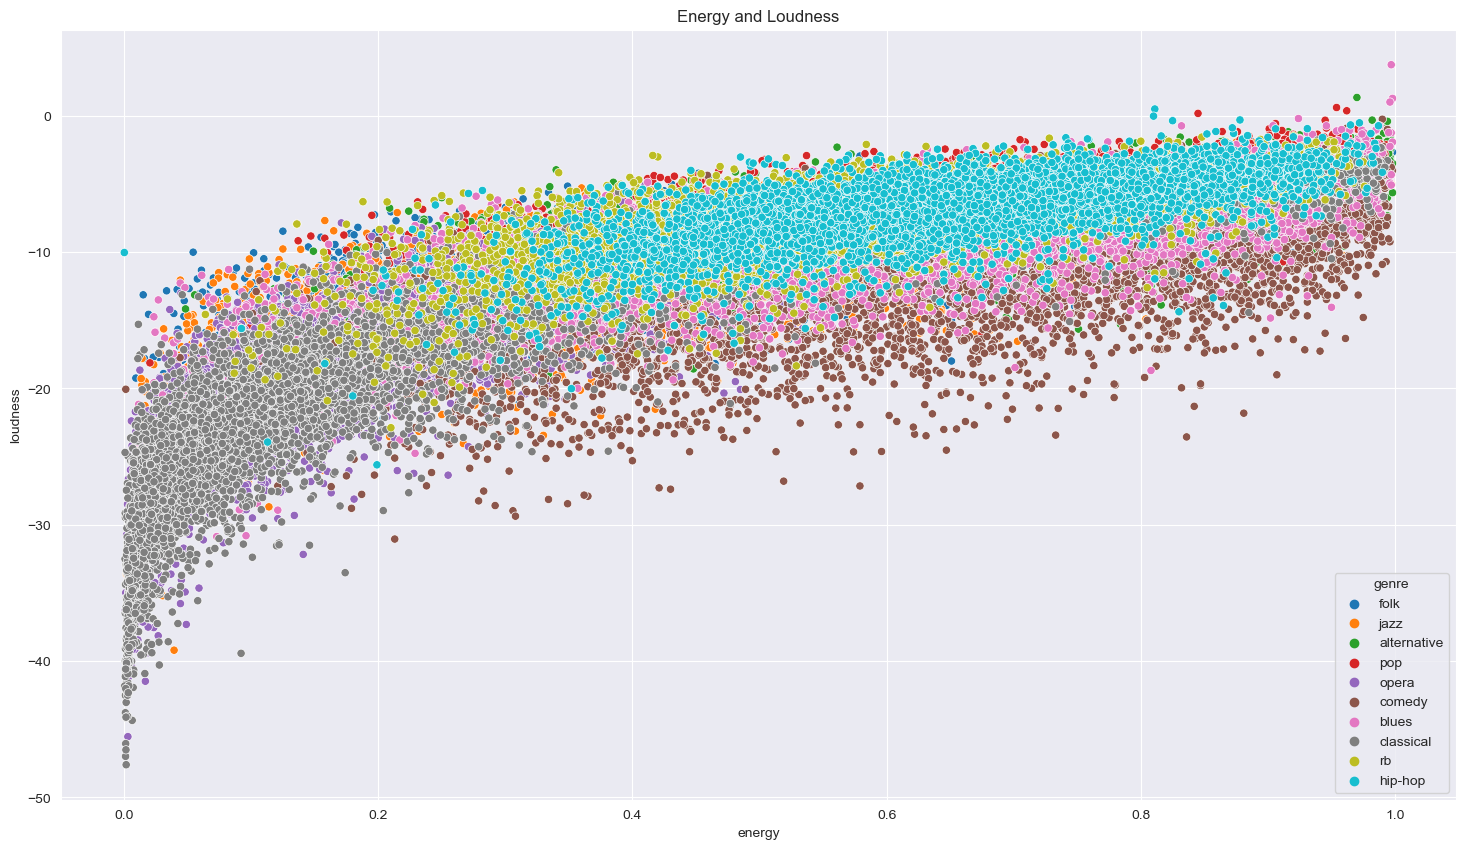

In [16]:
plt.figure(figsize=(18,10))

sns.scatterplot(data=train_df,x='energy',y='loudness',hue='genre').set(title='Energy and Loudness')

[Text(0.5, 1.0, 'Acousticness and Loudness')]

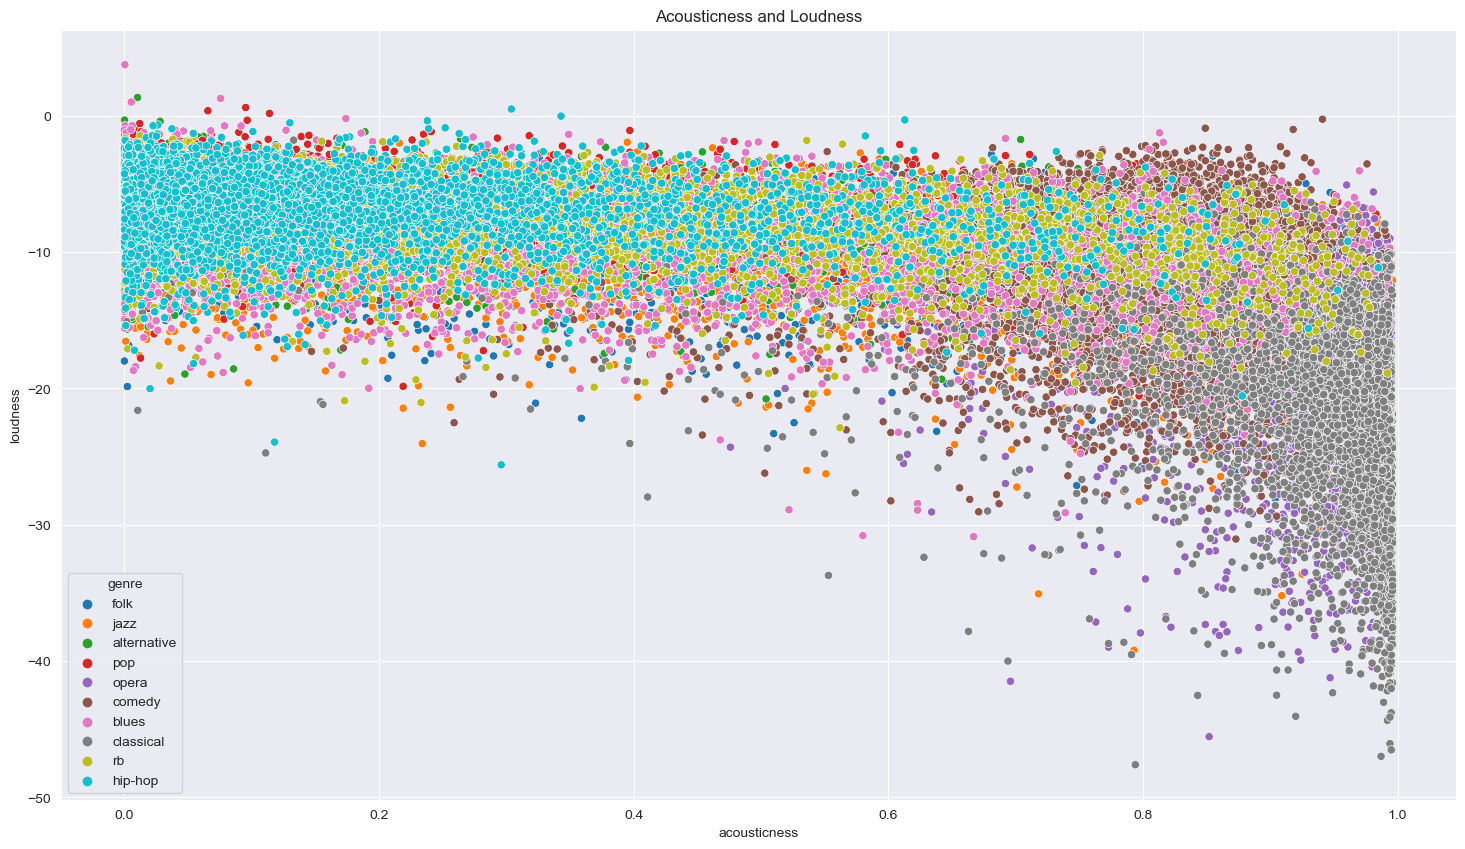

In [17]:
plt.figure(figsize=(18,10))

sns.scatterplot(data=train_df,x='acousticness',y='loudness',hue='genre').set(title='Acousticness and Loudness')

[Text(0.5, 1.0, 'Acousticness and Energy')]

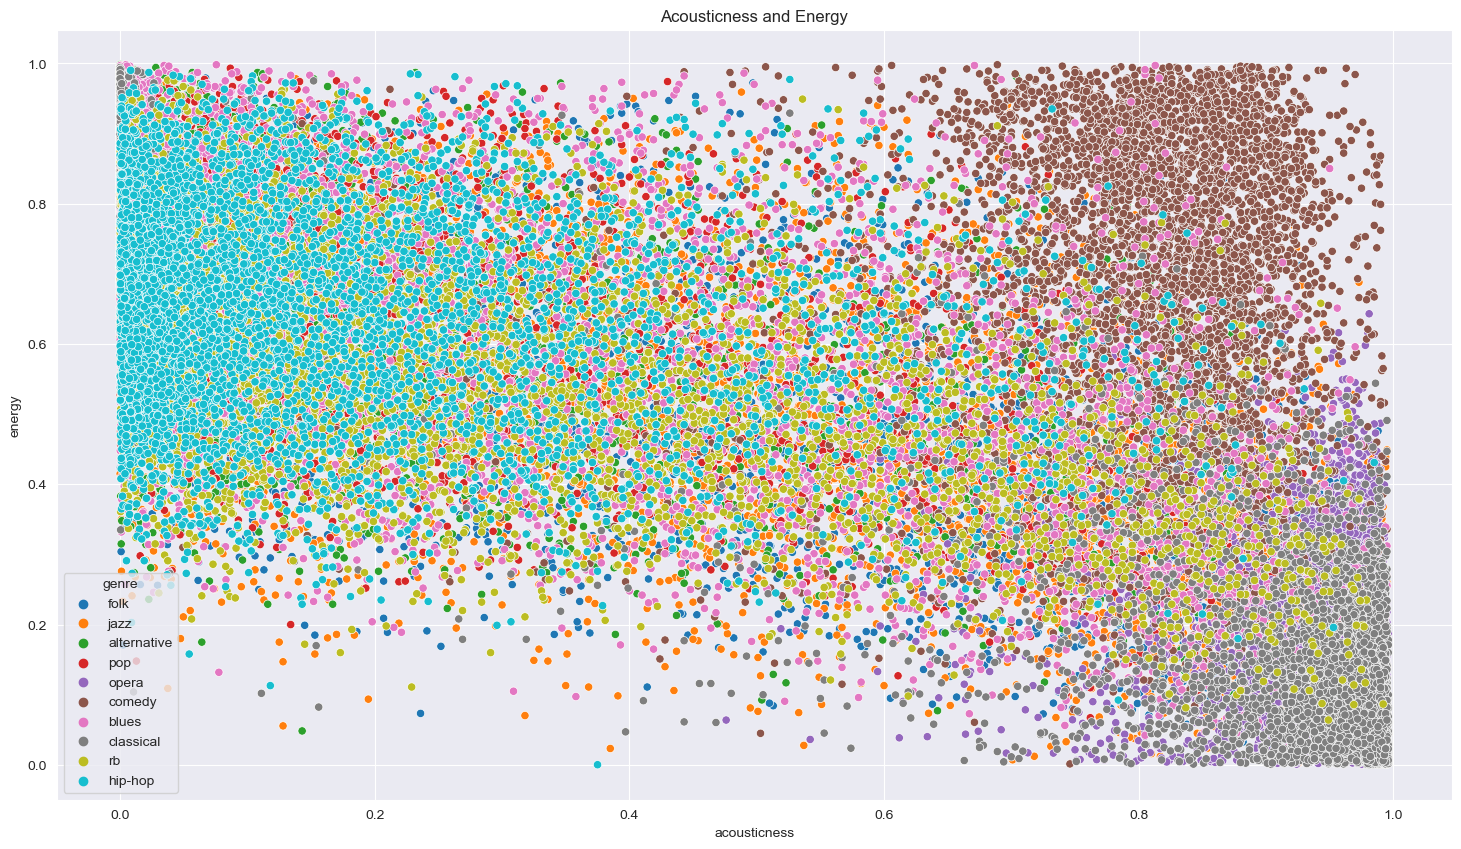

In [18]:
plt.figure(figsize=(18,10))

sns.scatterplot(data=train_df,x='acousticness',y='energy',hue='genre').set(title='Acousticness and Energy')

# Correlation Matrix (HeatMap)

In [19]:
num_cols = train_df.select_dtypes(include='number')
num_cols

instance_id  popularity  acousticness  danceability  duration_ms  \
0           41581          42       0.01060         0.544          NaN   
1          112136          43       0.00363         0.261     333027.0   
2          128900          40       0.83500         0.501     201800.0   
3          173682          41       0.96000         0.487          NaN   
4          196905          45       0.34900         0.349          NaN   
...           ...         ...           ...           ...          ...   
4995       131460          55       0.00745         0.839     237667.0   
4996       123400          54       0.16100         0.724          NaN   
4997       180590          67       0.09780         0.774     210094.0   
4998       125387          56       0.00355         0.692     178787.0   
4999       180321          57       0.01310         0.649     173793.0   

      energy  instrumentalness  liveness  loudness  speechiness    tempo  \
0      0.813          0.377000    0.3450    -8.871       0.0398  121.892   
1      0.572          0.001340    0.1580    -5.480       0.0323  114.052   
2      0.176          0.000629    0.1060   -12.868       0.0338      NaN   
3      0.223          0.007110    0.1210   -17.700       0.3670  175.357   
4      0.499          0.756000    0.1270    -6.832       0.0290  113.476   
...      ...               ...       ...       ...          ...      ...   
4995   0.551          0.000020    0.0800    -7.484       0.2290   88.727   
4996   0.556          0.000004    0.4870   -10.659       0.1480  120.060   
4997   0.656          0.000000    0.0643    -4.215       0.0357   95.007   
4998   0.533          0.000000    0.1140    -6.165       0.1760   78.902   
4999   0.717          0.000033    0.1800    -5.021       0.2620   86.798   

      valence  
0      0.5790  
1      0.0382  
2      0.1250  
3      0.6410  
4      0.1150  
...       ...  
4995   0.8520  
4996   0.2230  
4997   0.8540  
4998   0.2500  
4999   0.5890  

[50000 rows x 12 columns]

In [20]:
corr_matrix = num_cols.corr()
corr_matrix

instance_id  popularity  acousticness  danceability  \
instance_id          1.000000    0.005256     -0.001173     -0.003870   
popularity           0.005256    1.000000     -0.580503      0.473593   
acousticness        -0.001173   -0.580503      1.000000     -0.469053   
danceability        -0.003870    0.473593     -0.469053      1.000000   
duration_ms          0.004060   -0.093503      0.069308     -0.199263   
energy              -0.004607    0.359804     -0.683391      0.410504   
instrumentalness    -0.003165   -0.232497      0.300051     -0.341960   
liveness            -0.004662   -0.305581      0.169976     -0.023363   
loudness            -0.005386    0.532263     -0.699495      0.521791   
speechiness         -0.003773   -0.253954      0.188816      0.149198   
tempo               -0.004314    0.197416     -0.262275      0.070415   
valence             -0.002802    0.238476     -0.373630      0.534298   

                  duration_ms    energy  instrumentalness  liveness  loudness  \
instance_id          0.004060 -0.004607         -0.003165 -0.004662 -0.005386   
popularity          -0.093503  0.359804         -0.232497 -0.305581  0.532263   
acousticness         0.069308 -0.683391          0.300051  0.169976 -0.699495   
danceability        -0.199263  0.410504         -0.341960 -0.023363  0.521791   
duration_ms          1.000000 -0.089141          0.162864 -0.000124 -0.111787   
energy              -0.089141  1.000000         -0.380902  0.246308  0.812908   
instrumentalness     0.162864 -0.380902          1.000000 -0.176273 -0.471876   
liveness            -0.000124  0.246308         -0.176273  1.000000  0.023698   
loudness            -0.111787  0.812908         -0.471876  0.023698  1.000000   
speechiness         -0.047389  0.263411         -0.221183  0.671640  0.035961   
tempo               -0.040417  0.187683         -0.091872 -0.109692  0.217593   
valence             -0.167541  0.446253         -0.208982  0.005693  0.422711   

                  speechiness     tempo   valence  
instance_id         -0.003773 -0.004314 -0.002802  
popularity          -0.253954  0.197416  0.238476  
acousticness         0.188816 -0.262275 -0.373630  
danceability         0.149198  0.070415  0.534298  
duration_ms         -0.047389 -0.040417 -0.167541  
energy               0.263411  0.187683  0.446253  
instrumentalness    -0.221183 -0.091872 -0.208982  
liveness             0.671640 -0.109692  0.005693  
loudness             0.035961  0.217593  0.422711  
speechiness          1.000000 -0.131694  0.019304  
tempo               -0.131694  1.000000  0.140364  
valence              0.019304  0.140364  1.000000

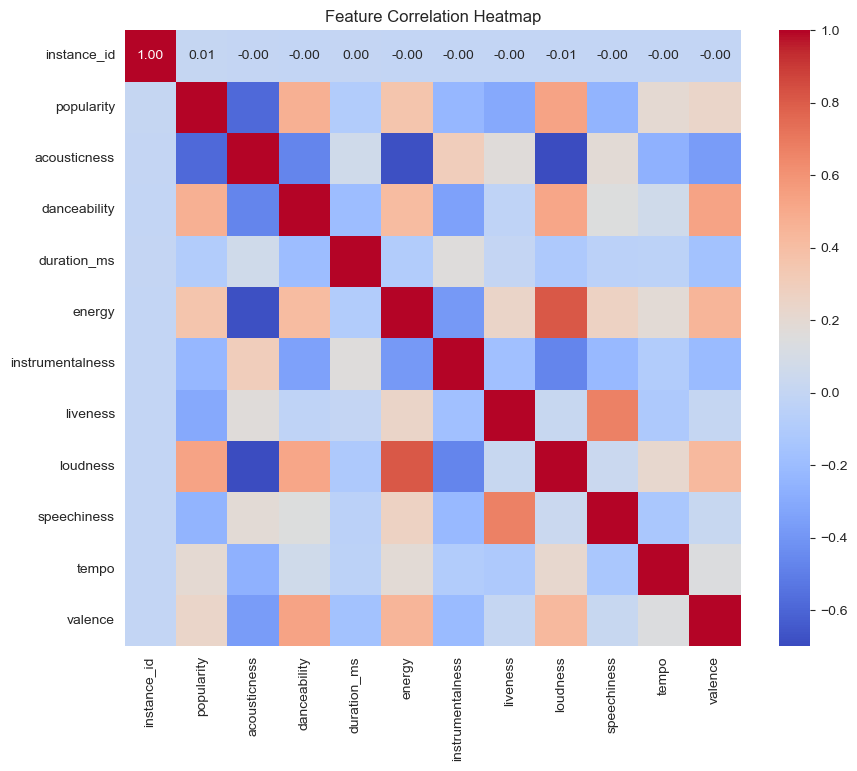

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Distributions

## Median Feature Values for Each Genre

In [22]:
for column in num_cols.columns:
    median = train_df.groupby(['genre'])[column].median()
    print(f'{column} median by genre:')
    print(median)
    print(f'Variance = {median.var()}')
    print('\n')

instance_id median by genre:
genre
alternative    118603.0
blues          117823.0
classical      119592.0
comedy         116654.0
folk           119030.5
hip-hop        120422.5
jazz           118579.0
opera          118786.0
pop            117613.0
rb             120507.5
Name: instance_id, dtype: float64
Variance = 1474438.4138888887


popularity median by genre:
genre
alternative    49.0
blues          33.0
classical      32.0
comedy         20.0
folk           49.0
hip-hop        57.0
jazz           40.0
opera          11.0
pop            66.0
rb             51.0
Name: popularity, dtype: float64
Variance = 288.4


acousticness median by genre:
genre
alternative    0.03235
blues          0.22900
classical      0.96700
comedy         0.82000
folk           0.44650
hip-hop        0.10700
jazz           0.52250
opera          0.96500
pop            0.12050
rb             0.21100
Name: acousticness, dtype: float64
Variance = 0.13118542224999996


danceability median by genre:
genre
alt

# Visualisations of Distributions

## Violin Plot

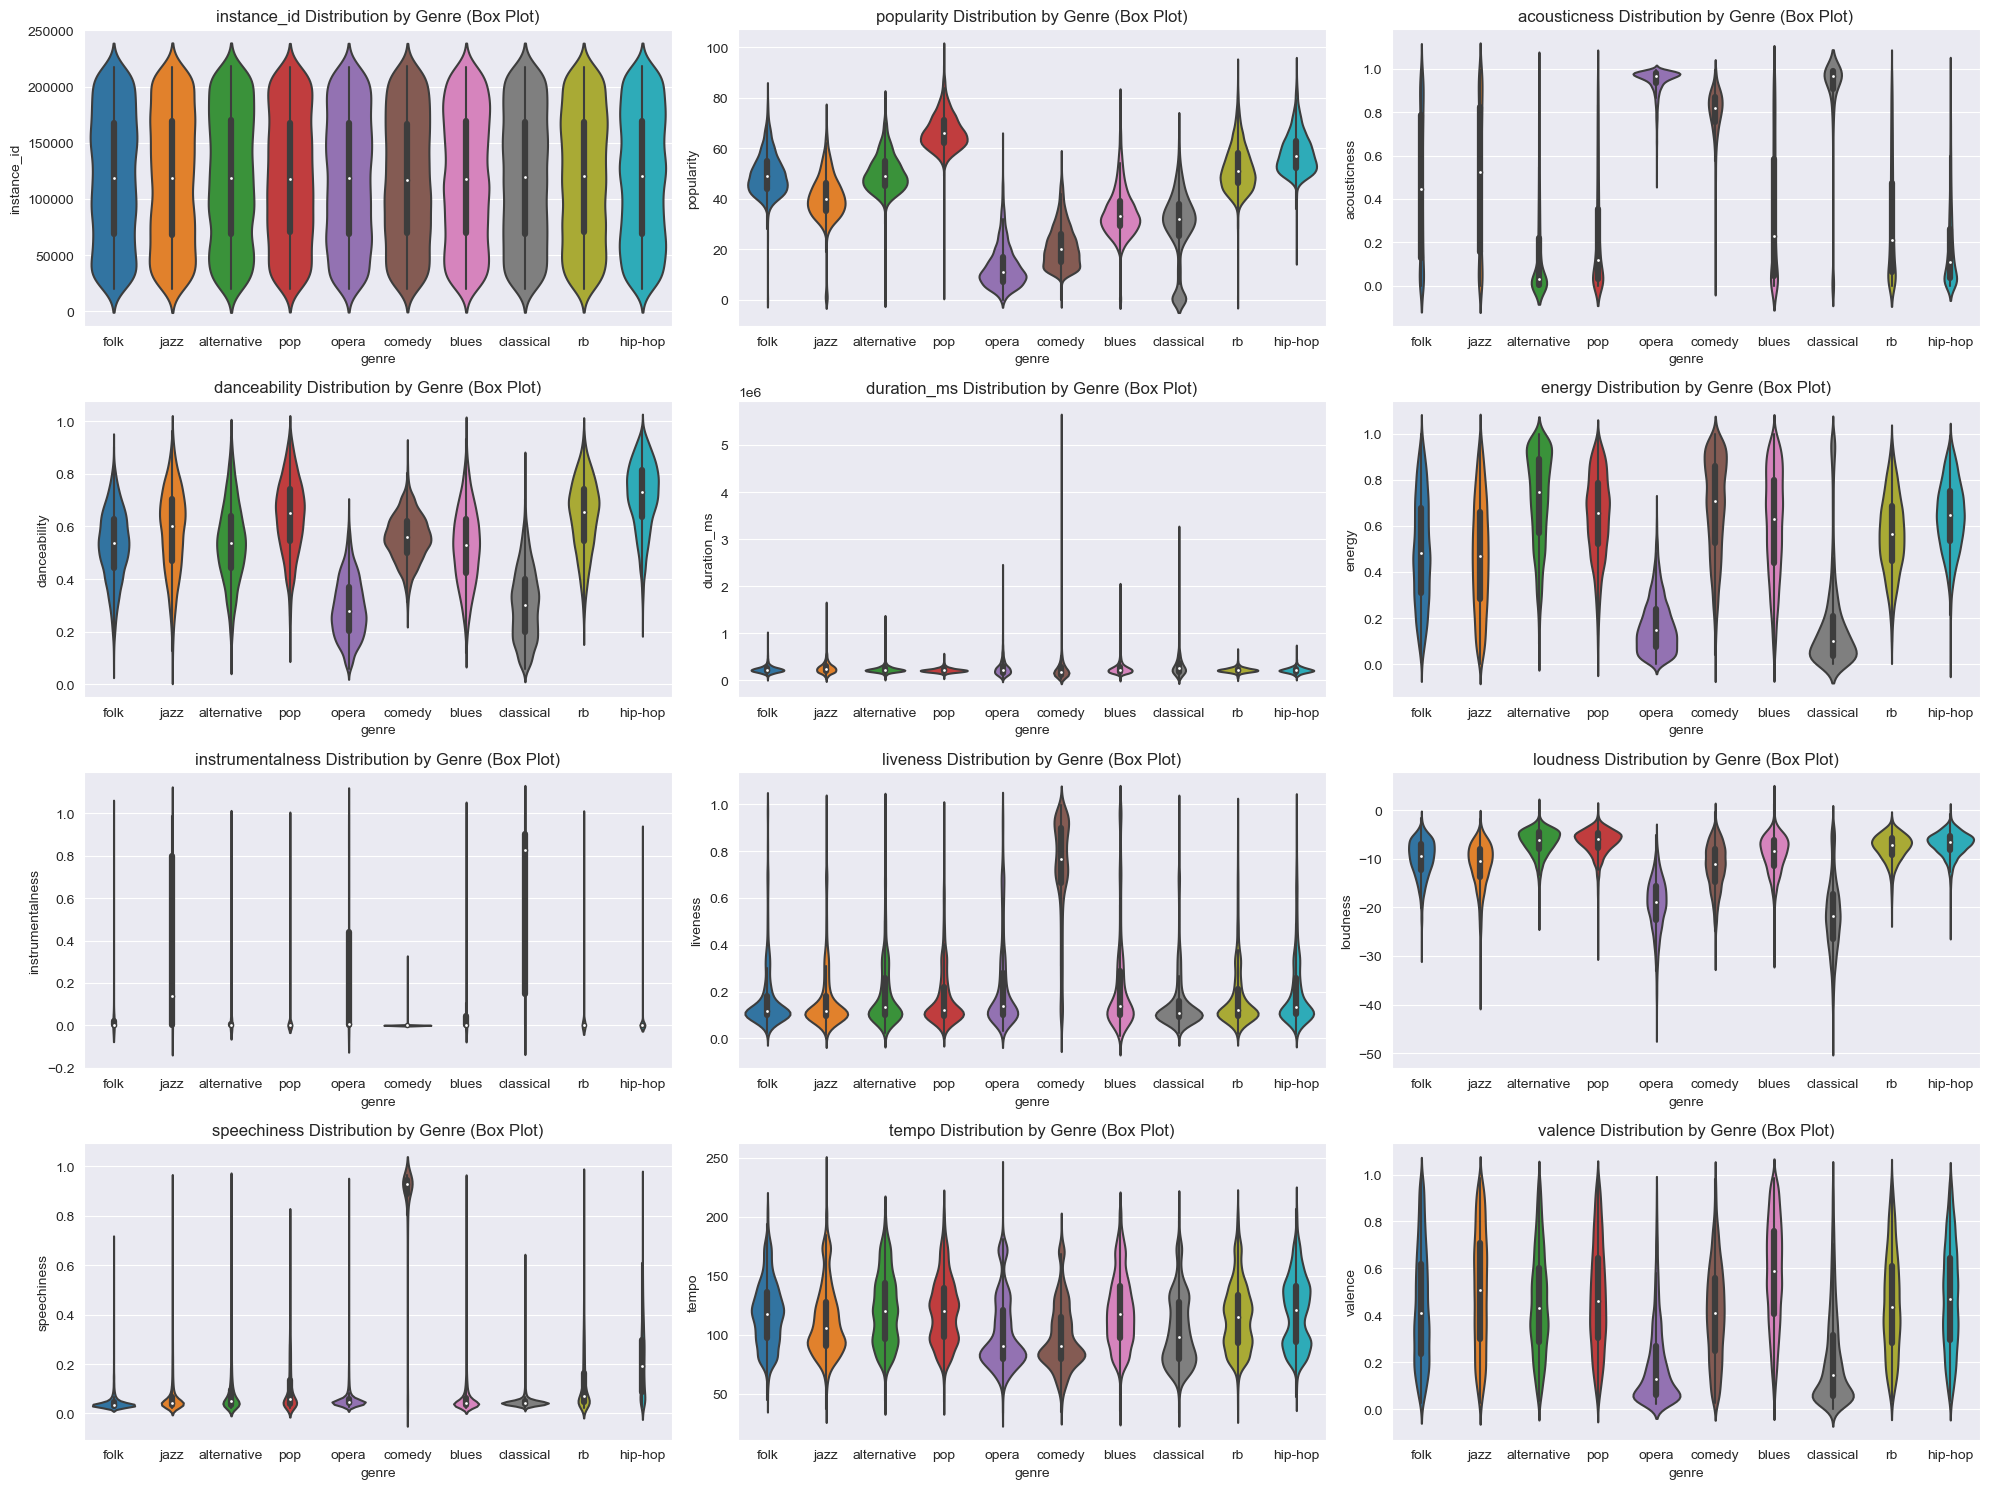

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for i, column in enumerate(num_cols.columns):
    sns.violinplot(x=train_df['genre'], y=column, data=train_df, ax=axes[i])
    axes[i].set_title(f'{column} Distribution by Genre (Box Plot)')

for j in range(i+1, 4*3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
    

## Box Plot

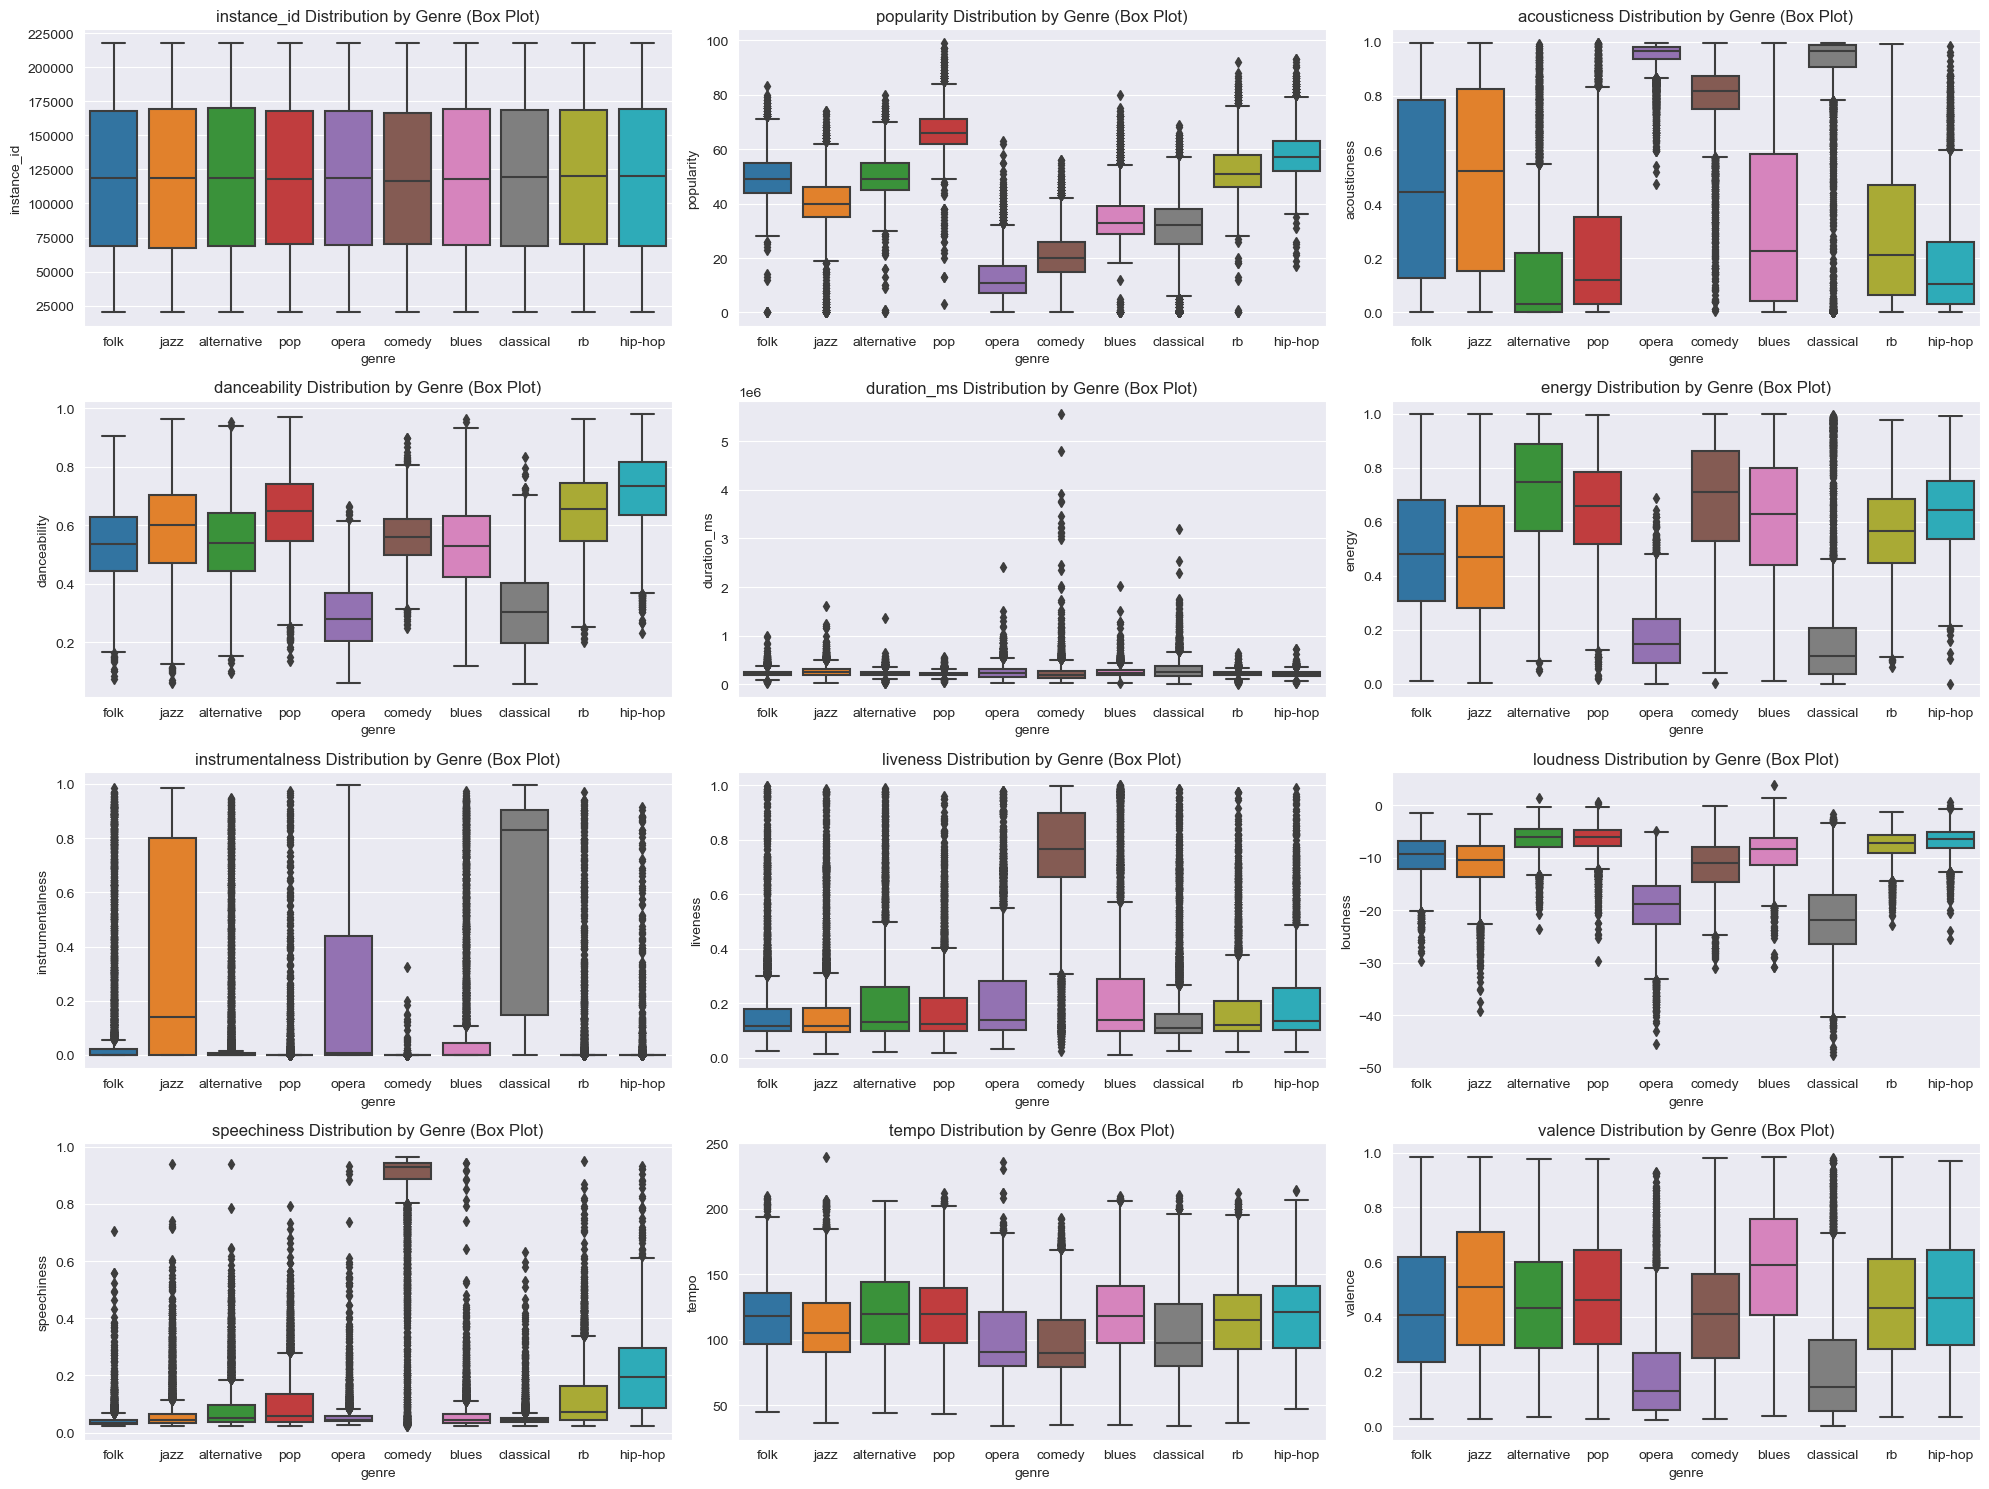

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for i, column in enumerate(num_cols.columns):
    sns.boxplot(x=train_df['genre'], y=column, data=train_df, ax=axes[i])
    axes[i].set_title(f'{column} Distribution by Genre (Box Plot)')

for j in range(i+1, 4*3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

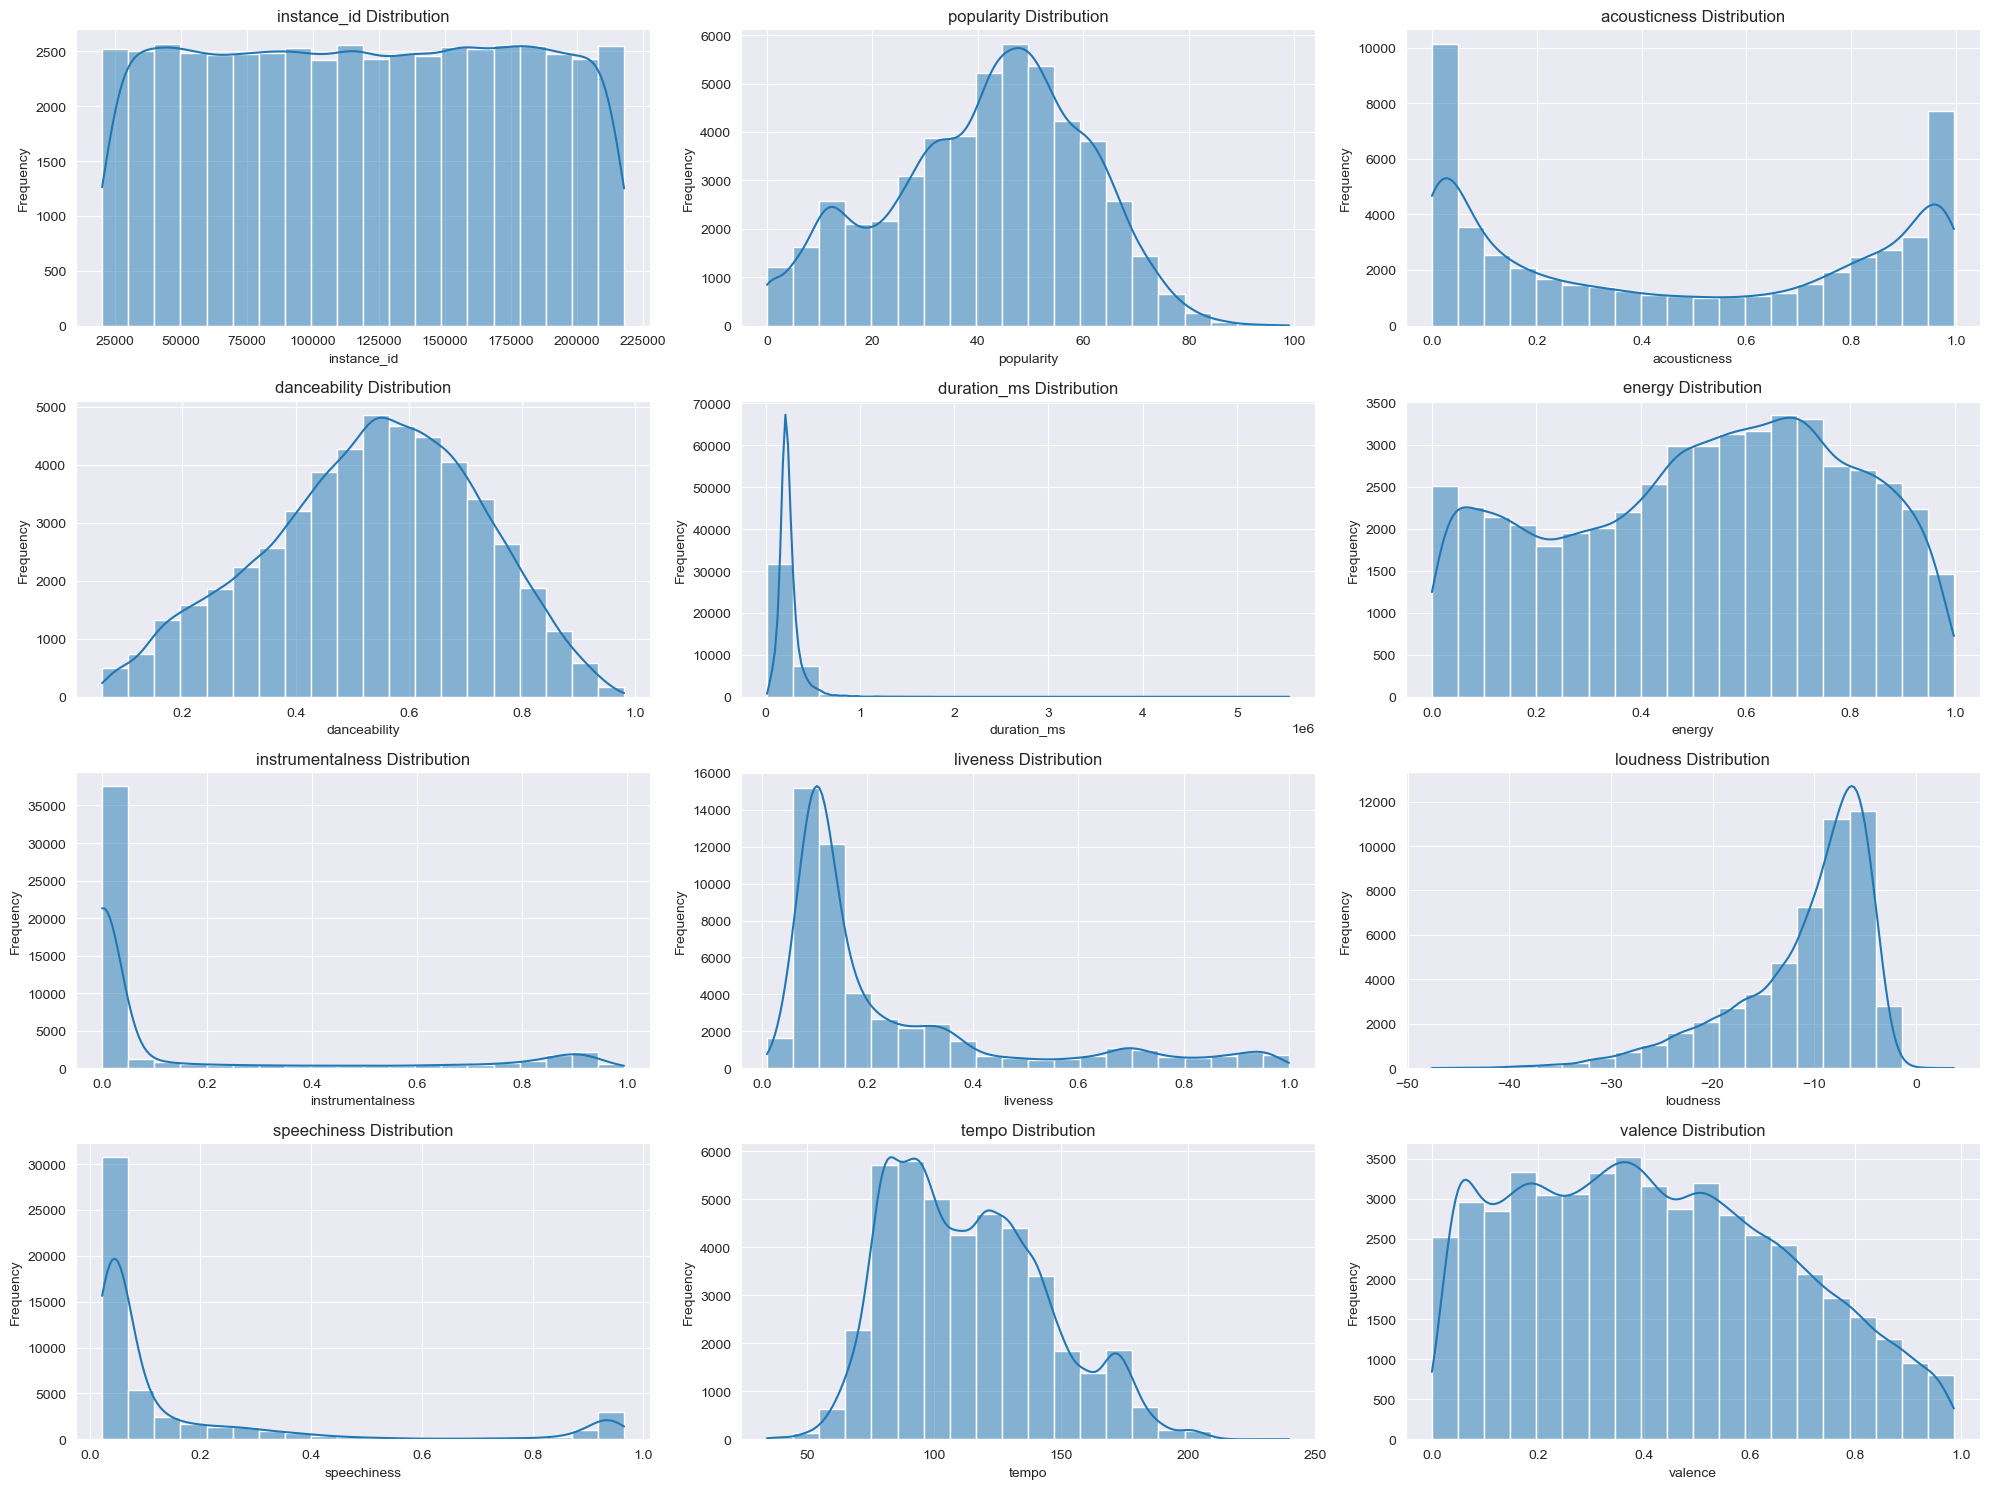

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for i, column in enumerate(num_cols):
    sns.histplot(train_df[column], bins=20, kde=True, ax=axes[i]) 
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, 4*3):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

# Preparing Data / Feature Engineering

In [26]:
train_df['is_standard_time'] = train_df['time_signature'].apply(lambda x: True if x == '04-Apr' else False)
train_df = train_df.drop(columns=['time_signature'])

test_df['is_standard_time'] = test_df['time_signature'].apply(lambda x: True if x == '04-Apr' else False)
test_df = test_df.drop(columns=['time_signature'])

# Preprocessing

## Preparing Encoders/Imputers

In [27]:
ohe = OneHotEncoder(sparse_output=False)
le = LabelEncoder()
KI = KNNImputer(n_neighbors=5)
scalar = StandardScaler()

In [28]:
le_cols = ['key']
ohe_cols = ['mode','is_standard_time']

## Removing Unhelpful Features

In [29]:
train_df.drop(columns=['instance_id','artist_name', 'track_name', 'track_id','key'], axis=1,inplace=True)
test_ids = test_df['instance_id'].copy()
test_df.drop(columns=['instance_id','artist_name', 'track_name', 'track_id','key'],axis=1,inplace=True)

In [30]:
X = train_df.drop(columns=['genre'],axis=1)
y = train_df['genre']
X_test = test_df

In [31]:
X.head()

popularity  acousticness  danceability  duration_ms  energy  \
0          42       0.01060         0.544          NaN   0.813   
1          43       0.00363         0.261     333027.0   0.572   
2          40       0.83500         0.501     201800.0   0.176   
3          41       0.96000         0.487          NaN   0.223   
4          45       0.34900         0.349          NaN   0.499   

   instrumentalness  liveness  loudness   mode  speechiness    tempo  valence  \
0          0.377000     0.345    -8.871  Major       0.0398  121.892   0.5790   
1          0.001340     0.158    -5.480  Major       0.0323  114.052   0.0382   
2          0.000629     0.106   -12.868  Minor       0.0338      NaN   0.1250   
3          0.007110     0.121   -17.700  Minor       0.3670  175.357   0.6410   
4          0.756000     0.127    -6.832  Major       0.0290  113.476   0.1150   

   is_standard_time  
0              True  
1              True  
2              True  
3              True  
4              True

## Train/Validation set Split

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [33]:
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [34]:
X_train.head()

popularity  acousticness  danceability  duration_ms  energy  \
0          52        0.1570         0.833     242093.0   0.680   
1          47        0.0435         0.318     826813.0   0.663   
2          71        0.0158         0.870     191410.0   0.656   
3          36        0.0108         0.243     249000.0   0.748   
4          11        0.8710         0.451     139027.0   0.135   

   instrumentalness  liveness  loudness   mode  speechiness    tempo  valence  \
0          0.000000     0.189    -5.408  Major       0.2270   98.996    0.641   
1          0.003910     0.937    -8.531  Major       0.0328  104.804    0.365   
2          0.000000     0.106    -5.081  Major       0.1170  162.835    0.416   
3          0.006510     0.120    -5.343  Major       0.0351   75.044    0.446   
4          0.000121     0.161   -18.609  Minor       0.0426  124.918    0.330   

   is_standard_time  
0              True  
1              True  
2              True  
3              True  
4              True

In [35]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        15000 non-null  int64  
 1   acousticness      15000 non-null  float64
 2   danceability      15000 non-null  float64
 3   duration_ms       11966 non-null  float64
 4   energy            15000 non-null  float64
 5   instrumentalness  15000 non-null  float64
 6   liveness          15000 non-null  float64
 7   loudness          15000 non-null  float64
 8   mode              15000 non-null  object 
 9   speechiness       15000 non-null  float64
 10  tempo             12695 non-null  float64
 11  valence           15000 non-null  float64
 12  is_standard_time  15000 non-null  bool   
dtypes: bool(1), float64(10), int64(1), object(1)
memory usage: 1.4+ MB


# Data Transformations

## Encode mode and is_standard_time cols

## Training/Validation Set

In [36]:
knn_imputer = KNNImputer(n_neighbors=5)

## OHE

In [37]:
X_train = pd.get_dummies(X_train,columns=ohe_cols)

In [38]:
X_valid = pd.get_dummies(X_valid,columns=ohe_cols)

In [39]:
X_train_cols = X_train.columns
X_valid_cols = X_valid.columns

## Impute

In [40]:
X_train = knn_imputer.fit_transform(X_train)
X_valid = knn_imputer.transform(X_valid)

In [41]:
X_train = pd.DataFrame(X_train, columns=X_train_cols)
X_valid = pd.DataFrame(X_valid, columns=X_valid_cols)

In [42]:
print(X_train.isnull().sum())

popularity                0
acousticness              0
danceability              0
duration_ms               0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
speechiness               0
tempo                     0
valence                   0
mode_Major                0
mode_Minor                0
is_standard_time_False    0
is_standard_time_True     0
dtype: int64


X_train

## Scale numerical columns

In [43]:
scale = StandardScaler()

In [44]:
num_cols = num_cols.drop(columns=['instance_id'])
number_cols = num_cols.columns

In [45]:
X_train[number_cols] = scale.fit_transform(X_train[number_cols])
X_valid[number_cols] = scale.transform(X_valid[number_cols])

In [46]:
X_valid

popularity  acousticness  danceability  duration_ms    energy  \
0        2.073842      0.626519     -0.705017    -0.344512 -0.433392   
1       -1.549681      1.351417      0.560949    -1.227170 -1.780274   
2       -0.684362      1.364693     -0.215652     0.005556 -1.592576   
3       -0.413950     -0.071825      0.630099    -0.167244  1.025669   
4        1.316688     -0.900280      0.199245    -0.474659  0.963347   
...           ...           ...           ...          ...       ...   
14995    0.126874      0.100769      1.156698    -0.398831 -0.492048   
14996   -0.359868      0.881428      0.385416    -0.519275  1.626890   
14997    0.018709      1.377970     -1.056083    -0.792485 -1.807769   
14998   -1.225186      1.319553     -1.205020    -0.077740 -1.056609   
14999   -1.766011      1.377970     -1.518852     0.191300 -1.005285   

       instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0             -0.495162 -0.632767  0.299435     0.064132  2.296761 -0.624284   
1              2.597793 -0.664884 -3.099698    -0.483237  0.169047  0.074127   
2              2.477678 -0.627200 -1.113071    -0.463688 -0.527092 -1.270212   
3              2.427630 -0.706423  0.166854    -0.514906 -0.820825  1.357910   
4             -0.495162 -0.179701  1.215547    -0.217372  2.499156 -0.640432   
...                 ...       ...       ...          ...       ...       ...   
14995         -0.495162 -0.646471 -0.184554    -0.498876  0.010819  1.200465   
14996         -0.495162  0.235682  0.533807     2.883081 -0.268064 -1.286361   
14997          2.427630 -0.622062 -2.799708    -0.489102 -1.343887 -1.446228   
14998          2.324198 -0.261064 -0.583942    -0.504741  0.047389 -0.789803   
14999         -0.144827 -0.479461 -0.722203    -0.475808 -1.077918 -1.177360   

       mode_Major  mode_Minor  is_standard_time_False  is_standard_time_True  
0             0.0         1.0                     0.0                    1.0  
1             1.0         0.0                     0.0                    1.0  
2             0.0         1.0                     0.0                    1.0  
3             1.0         0.0                     0.0                    1.0  
4             1.0         0.0                     0.0                    1.0  
...           ...         ...                     ...                    ...  
14995         1.0         0.0                     0.0                    1.0  
14996         1.0         0.0                     1.0                    0.0  
14997         1.0         0.0                     1.0                    0.0  
14998         1.0         0.0                     0.0                    1.0  
14999         1.0         0.0                     1.0                    0.0  

[15000 rows x 15 columns]

## Apply the same preprocessing to test_df

In [47]:
X_test = pd.get_dummies(X_test, columns=['mode','is_standard_time'])

In [48]:
X_test_cols = X_test.columns

In [49]:
X_test = knn_imputer.transform(X_test)

X_test = pd.DataFrame(X_test, columns=X_test_cols)

In [50]:
X_test[number_cols] = scale.transform(X_test[number_cols])  

In [51]:
X_test = pd.DataFrame(X_test,columns=X_test_cols)

In [52]:
X_test

popularity  acousticness  danceability  duration_ms    energy  \
0       -0.738445      1.314242     -0.736932     2.291945 -1.489195   
1        0.667699     -0.820620      1.092868    -0.053255  0.556423   
2       -0.197620     -1.043666     -0.226290    -0.391379  1.007339   
3        0.072792      1.043401      0.560949    -0.597117 -1.261904   
4       -0.197620      0.544205      0.544992     0.606633  0.219153   
...           ...           ...           ...          ...       ...   
12430    0.289122     -0.233799      0.837547     0.090785  0.127503   
12431    1.262605     -1.111907      0.034350    -0.306197  0.578419   
12432   -0.413950      0.823011      0.263075     0.689400 -0.404064   
12433    0.938111     -1.091196      1.832235    -0.538258  1.579232   
12434    0.721781      1.054023     -0.183737     0.204948 -1.571679   

       instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0             -0.493891  2.355417 -1.413060    -0.432410  0.458739 -0.503172   
1             -0.495162 -0.102619  0.882524     0.197064 -0.544669 -0.721173   
2             -0.495139  0.869461  0.328134    -0.510605  0.603990  1.858505   
3             -0.495162 -0.622062 -0.792156    -0.480891 -0.508721  0.469758   
4             -0.494978 -0.744107  0.380001    -0.455477  0.236938  1.620319   
...                 ...       ...       ...          ...       ...       ...   
12430         -0.491325 -0.089772  0.300781    -0.499267 -0.683869  0.946131   
12431         -0.292302 -0.565107  0.694339    -0.337793 -0.823587 -0.446653   
12432          0.619236 -0.410944 -0.122523    -0.515688 -0.708401  0.029719   
12433         -0.495115 -0.436638  1.187147    -0.400350 -0.129002  1.579948   
12434         -0.494425 -0.573672 -1.403046    -0.455868  1.369428 -0.006614   

       mode_Major  mode_Minor  is_standard_time_False  is_standard_time_True  
0             1.0         0.0                     0.0                    1.0  
1             1.0         0.0                     0.0                    1.0  
2             1.0         0.0                     0.0                    1.0  
3             0.0         1.0                     0.0                    1.0  
4             1.0         0.0                     0.0                    1.0  
...           ...         ...                     ...                    ...  
12430         1.0         0.0                     0.0                    1.0  
12431         1.0         0.0                     0.0                    1.0  
12432         0.0         1.0                     0.0                    1.0  
12433         0.0         1.0                     0.0                    1.0  
12434         1.0         0.0                     0.0                    1.0  

[12435 rows x 15 columns]

# Modelling

## Hyperparameter tuning using RandomizedCV with Stratified KfoldCross

In [53]:
#rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)
#y_hat = rfc.predict(X_valid)

#accuracy = accuracy_score(y_valid,y_hat)

In [54]:
'''
param_grid = {
    'n_estimators': [150, 200, 300],
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 15,20],
    'min_samples_leaf': [2, 4, 5, 6],
    'criterion': ['gini', 'entropy'],
}
'''

In [55]:
'''CV_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv=StratifiedKFold(n_splits=5),n_jobs=-1,n_iter=50)'''

In [56]:
''''#CV_rfc.fit(X_train,y_train)

best_rfc = CV_rfc.best_estimator_
best_params = CV_rfc.best_params_
best_score = CV_rfc.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)'''

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'gini'}

## Random Forest Classifier

In [ ]:
genre_mapping = {
    'alternative': 'Alternative',
    'blues': 'Blues',
    'classical': 'Classical',
    'comedy': 'Comedy',
    'folk': 'Folk',
    'hip-hop': 'Hip-Hop',
    'jazz': 'Jazz',
    'opera': 'Opera',
    'pop': 'Pop',
    'rb': 'R&B'
}

rfc = RandomForestClassifier(n_estimators = 300, min_samples_split = 15, min_samples_leaf = 2, max_depth = 15, criterion = 'gini')

rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)

y_pred_formatted = [genre_mapping.get(genre, genre) for genre in y_pred]
y_pred_df = pd.DataFrame({
    'instance_id': test_ids,
    'genre': y_pred_formatted
})

# Save the predictions to a CSV file with the required format
y_pred_df.to_csv('attemptRF.csv', index=False)

print(y_pred_df.head())

## Gradient Boosting

In [ ]:
genre_mapping = {
    'alternative': 'Alternative',
    'blues': 'Blues',
    'classical': 'Classical',
    'comedy': 'Comedy',
    'folk': 'Folk',
    'hip-hop': 'Hip-Hop',
    'jazz': 'Jazz',
    'opera': 'Opera',
    'pop': 'Pop',
    'rb': 'R&B'
}

rfc = GradientBoostingClassifier()

rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)

y_pred_formatted = [genre_mapping.get(genre, genre) for genre in y_pred]
y_pred_df = pd.DataFrame({
    'instance_id': test_ids,
    'genre': y_pred_formatted
})

# Save the predictions to a CSV file with the required format
y_pred_df.to_csv('attemptGB.csv', index=False)

print(y_pred_df.head())

## Hyperparameter Tuning XGBoost

In [ ]:
'''import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

xgboost_clf = xgb.XGBClassifier()

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],           
    'max_depth': randint(3, 10),                    
    'learning_rate': uniform(0.01, 0.3),            
    'subsample': uniform(0.5, 1.0),                 
    'colsample_bytree': uniform(0.5, 1.0),          
    'min_child_weight': randint(1, 10),             
    'gamma': uniform(0, 5),                        
    'reg_alpha': uniform(0, 1),                     
    'reg_lambda': uniform(0.5, 1.5)                 
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5)

# Create the RandomizedSearchCV object
random_search_xgb = RandomizedSearchCV(
    estimator=xgboost_clf, 
    param_distributions=param_grid, 
    n_iter=50,               
    cv=cv_strategy,          
    verbose=1,               
    n_jobs=-1,               
    random_state=42          
)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params = random_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params)

# Use the best model to make predictions
best_xgb_model = random_search_xgb.best_estimator_

print(f'BEST XGB ESTIMATOR = {best_xgb_model}')'''

best hypers for XGB 'colsample_bytree': 0.5314291856867343, 'gamma': 3.182052056318902, 'learning_rate': 0.104306794322898, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0.6044173792778172, 'reg_lambda': 1.3097616369525098, 'subsample': 0.7030612247347694

## XGBoost classifier (Best performer)

In [ ]:
import xgboost as xgb

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

genre_mapping = {
    'alternative': 'Alternative',
    'blues': 'Blues',
    'classical': 'Classical',
    'comedy': 'Comedy',
    'folk': 'Folk',
    'hip-hop': 'Hip-Hop',
    'jazz': 'Jazz',
    'opera': 'Opera',
    'pop': 'Pop',
    'rb': 'R&B'
}

xgb = XGBClassifier(colsample_bytree = 0.5314291856867343, gamma = 3.182052056318902, learning_rate = 0.104306794322898, max_depth = 6, min_child_weight = 5, n_estimators = 300, reg_alpha = 0.6044173792778172, reg_lambda = 1.3097616369525098, subsample = 0.7030612247347694)

xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

y_train = label_encoder.inverse_transform(y_train)
y_valid = label_encoder.inverse_transform(y_valid)
y_pred = label_encoder.inverse_transform(y_pred)

y_pred_formatted = [genre_mapping.get(genre, genre) for genre in y_pred]
y_pred_df = pd.DataFrame({
    'instance_id': test_ids,
    'genre': y_pred_formatted
})

# Save the predictions to a CSV file with the required format
y_pred_df.to_csv('attemptGB.csv', index=False)

print(y_pred_df.head())

# Other Classifiers with default Params

## Neural Net

In [53]:
mlp = MLPClassifier()

mlp.fit(X_train,y_train)

print(mlp.score(X_valid,y_valid))

0.6502


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## KNN

In [54]:
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train,y_train)

y_hat = clf.predict(X_valid)

print(f'Acc: {accuracy_score(y_valid,y_hat)}')

Acc: 0.5369333333333334
